In [51]:
# Imports
import os 
import sys
import torch 
import pandas as pd
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from utils import download_fm, get_preds_figure
from sklearn.metrics import confusion_matrix, matthews_corrcoef

print("Loading torchvision...")
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
print("Torchvision loaded succesfully...")

Loading torchvision...
Torchvision loaded succesfully...


In [2]:
# Check does your computer support using GPU
print("GPU_available={}".format(torch.cuda.is_available()))

print(os.listdir())

GPU_available=True
['train.csv', 'net.pth', 'utils.py', 'logs', 'tb_graphs', 'stft_data_improved.zip', 'valid.csv', 'fNIRS_SQA_DL.ipynb', '.ipynb_checkpoints', 'dummy_data', 'test.csv', 'training_history.xlsx', '__pycache__', 'CNN_Vital108tf_sqi2111.ipynb', 'data', 'tensorboard_test.ipynb', 'stft_data_improved']


# 1 LOAD AND VERIFY DATA

### Formatting information for notebooks
You can transform a python cell to a **markdown** cell by going to cell and pressing ESC+m+ENTER.  
You can enter a new **python** cell by executing SHIFT+ENTER  
To enter a new line, type two or more spaces at the end of row and press enter

In [39]:
class fNIRS_SQA_Dataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = [0, 1]

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        image = image.convert("RGB")
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            #image = (image - image.mean()) / image.std()
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

In [4]:
# Select dataset
dataset_name = "stft_data_improved"

if dataset_name == "dummy":
    dirName = "./dummy_data"
    trainF = dirName + '/train_dummy.csv'
    validF = dirName + '/valid_dummy.csv'
    testF = dirName + '/test_dummy.csv'
elif dataset_name == "original_stft":
    dirName = '.'
elif dataset_name == "stft_data_improved":
    dirName = "./stft_data_improved"

if dataset_name != "dummy":
    trainF = dirName + '/train.csv'
    validF = dirName + '/valid.csv'
    testF = dirName + '/test.csv'

In [ ]:
# Try to load some data to verify it's RGB

test = fNIRS_SQA_Dataset(csv_file=trainF, transform=transforms.Compose([
                                            transforms.ToTensor()                                        ]))

dataload_test = DataLoader(test, 2, shuffle=True, num_workers=1)
_iter = iter(dataload_test)
samples = next(_iter)
images = samples['image']

print(np.shape(images))

torch.Size([2, 3, 250, 334])


Randomly show some images in training, validation and testing data and check if the images have correct labels. We also check the number of images for each class, to make sure the dataset created correctly.

In [6]:
def visualizeData(dataset, idx):
    fig = plt.figure(figsize=(16, 8))

    for i in range(len(idx)):
        image, label = dataset[idx[i]]['image'], dataset[idx[i]]['label']
        label_name = dataset.label_names[label]

        ax = plt.subplot(1, num_to_show, i + 1)
        plt.tight_layout()
        ax.set_title('class #{}'.format(label_name))
        ax.axis('off')
        #plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)
        plt.imshow(np.asarray(image))

    plt.show()

In [ ]:
def showNoSamplesPerLabel(dataset):
    # Print the number of images per class in the training set
    class_num = np.zeros(2, dtype=np.int32)
    print("Start...")
    for x in dataset:
        class_num[x['label']] += 1
    print("Images printed...")
    for i in range(0, 2):
        print('numer of images for class {}: {}'.format(dataset.label_names[i], class_num[i]))
    print("Done...")

Image shape:  (250, 334, 3)
<PIL.Image.Image image mode=RGB size=334x250 at 0x7F5E82395B80> <class 'PIL.Image.Image'>
Image shape:  (250, 334, 3)
<PIL.Image.Image image mode=RGB size=334x250 at 0x7F5E81D32820> <class 'PIL.Image.Image'>
Image shape:  (250, 334, 3)
<PIL.Image.Image image mode=RGB size=334x250 at 0x7F5E81D1BA30> <class 'PIL.Image.Image'>
Image shape:  (250, 334, 3)
<PIL.Image.Image image mode=RGB size=334x250 at 0x7F5E81C74520> <class 'PIL.Image.Image'>
Image shape:  (250, 334, 3)
<PIL.Image.Image image mode=RGB size=334x250 at 0x7F5E81C56460> <class 'PIL.Image.Image'>


/run/nvme/job_19502605/tmp/ipykernel_267093/106441750.py:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_name = train_set.label_names[label]


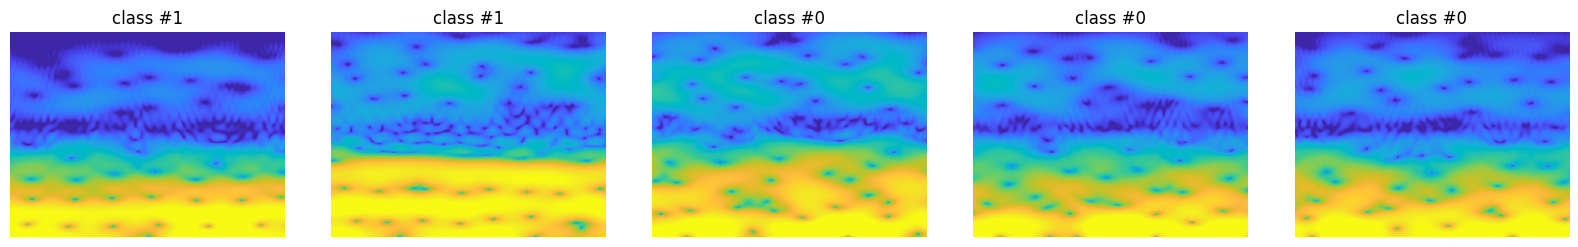

total number of training set: 3070
numer of images for class 0: 1535
numer of images for class 1: 1535


In [8]:
# Create a train_set from the train.csv file without any transformations

train_set = fNIRS_SQA_Dataset(csv_file=trainF, transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    print("Image shape: ", np.shape(image))
    print(image, type(image))
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))
    #plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)
plt.show()

# Print the number of total images in the training set
print('total number of training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(2, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(2):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], class_num_train[i]))

/run/nvme/job_19502605/tmp/ipykernel_267093/1494085256.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_name = dataset.label_names[label]


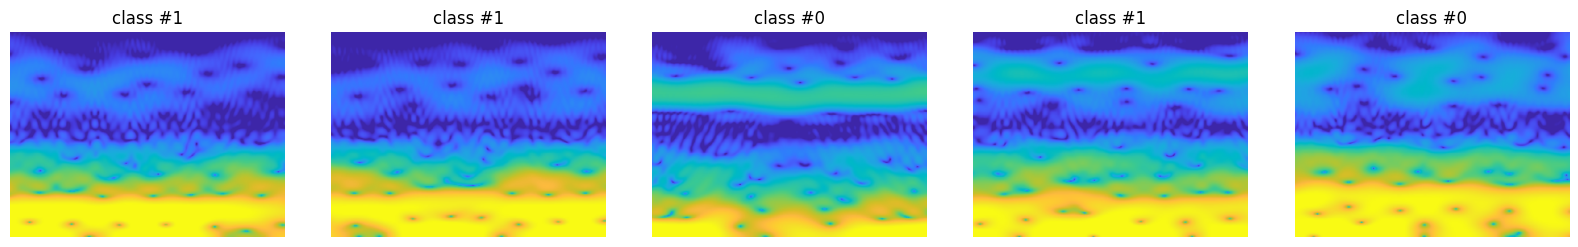

total number of images in validation set: 508
Start...
Imagess printed...
numer of images for class 0: 254
numer of images for class 1: 254
Done...


In [9]:

# load and checking validation data
# Create a valid_set from the val.csv file without any transformations
valid_set = fNIRS_SQA_Dataset(csv_file=validF, transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

# Show plots
visualizeData(valid_set, idx)

# Print the number of total images in the validation set    
print('total number of images in validation set: {}'.format(len(valid_set)))

# Print the number of images per class in the validation set
showNoSamplesPerLabel(valid_set)


/run/nvme/job_19502605/tmp/ipykernel_267093/1494085256.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_name = dataset.label_names[label]


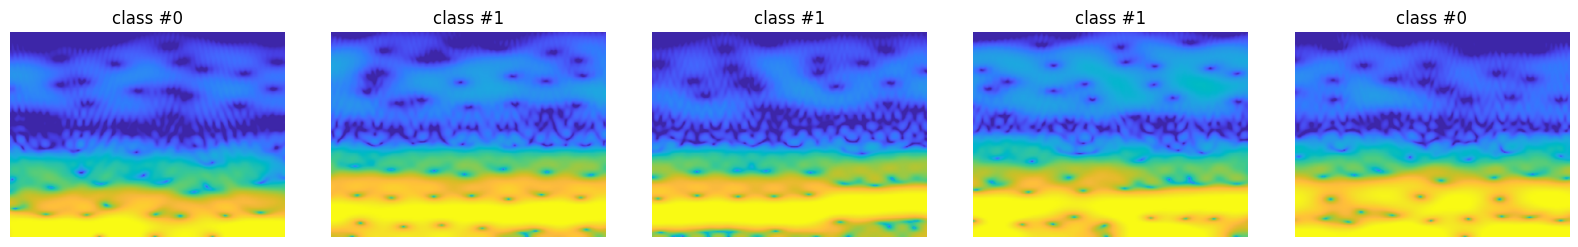

total number of images in test set: 566
Start...
Imagess printed...
numer of images for class 0: 283
numer of images for class 1: 283
Done...


In [10]:

# Check testing data
# Create a test_set from the test.csv file without any transformations
test_set =  fNIRS_SQA_Dataset(csv_file=testF, transform=None)
num_to_show = 5
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False)

# Show plots
visualizeData(test_set, idx)

# Print the number of total images in the testing set    
print('total number of images in test set: {}'.format(len(test_set)))

    
# Print the number of images per class in the testing set
showNoSamplesPerLabel(test_set)


# 2 BUILD CNN

![title](network.png)

In [11]:
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 

        # define layers 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=4, stride=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat6 = nn.Flatten(start_dim=1)
        
        self.fc7 = nn.Linear(in_features=900, out_features=30)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(0.5)

        self.fc9 = nn.Linear(in_features=30, out_features=20)
        self.relu9 = nn.ReLU()

        self.fc10 = nn.Linear(in_features=20, out_features=1)
        self.sigmoid10 = nn.Sigmoid()
        
    def forward(self, x):
        # OUTPUT: 0 or 1
        
        #print("Input shape: ", np.shape(x))
        #print("Input type: ", type(x))
        
        x = self.conv1(x)
        x = self.relu1(x)
        
        #print("Shape before 1st maxpool: ", np.shape(x))
        x = self.max_pool1(x)
        
        #print("Shape after 1st maxpool: ", np.shape(x))

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)
        
        #print("Shape after 2nd maxpool: ", np.shape(x))

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.max_pool3(x)

        #print("Shape after 3rd maxpool: ", np.shape(x))

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.max_pool4(x)

        #print("Shape after 4th maxpool: ", np.shape(x))
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.max_pool5(x)

        #print("Shape after 5th maxpool: ", np.shape(x))
        
        x = self.flat6(x)

        x = self.fc7(x)
        x = self.relu7(x)

        x = self.dropout8(x)

        x = self.fc9(x)
        x = self.relu9(x)

        x = self.fc10(x)
        x = self.sigmoid10(x)
        
        x = x.squeeze()
                
        return x
    

## 2.1 Create dataloaders

In [40]:
def getTrainingData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    """
    # transforms.Compose create a list of transformations
    transformed_training = fNIRS_SQA_Dataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    """

    transformed_training = fNIRS_SQA_Dataset(csv_file=csv_file, transform=transforms.Compose([
                                            transforms.ToTensor(),
                                        ]))
    
    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_training

def getEvalData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    """
    transformed_eval =  FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
                                        """
    transformed_eval = fNIRS_SQA_Dataset(csv_file=csv_file, transform=transforms.Compose([
                                            transforms.ToTensor(),
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_eval

def getTestData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    
    """
    transformed_test = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
                                        """
    transformed_test = fNIRS_SQA_Dataset(csv_file=csv_file, transform=transforms.Compose([
                                            transforms.ToTensor()
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_test = DataLoader(transformed_test, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_test

# 3 TRAIN

In [41]:
# Loaders

# Set batch_size to 64, shuffling the training set and use 2 workers to do parallel reading.
mini_batch = 32
train_loader = getTrainingData(csv_file=trainF, batch_size=mini_batch, num_workers=2)
valid_loader = getEvalData(csv_file=validF, batch_size=mini_batch, num_workers=2)
test_loader = getTestData(csv_file=testF, batch_size=mini_batch, num_workers=2)

Writers done
Network(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=4, stride=3, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(30, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(30, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(30, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu4): ReLU()
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(30, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu5): ReLU()
  (max_pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat6): Flatten(start_dim=1, end_dim=-1)
  (fc7): L

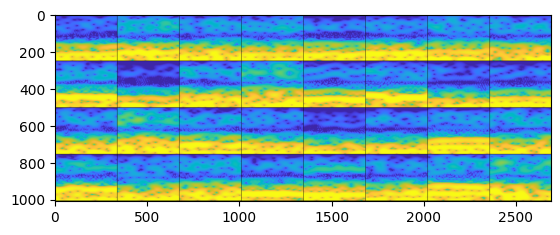

In [42]:
# Create a train writer and a validation writer
# After training, to open tensorboard run
# tensorboard --logdir tb_graphs/ --port 5656
# The above command use to run a tensorboard for data in ./tb_graphs folder in port 5656
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

print("Writers done")

# Switch between models
use_resnet18 = False
if not use_resnet18:
    # instantiate a network
    net = Network(num_classes=2)
else:
    # instantiate ResNet-18 model
    net = ResNet18_Fashion_MNIST(num_classes=2)
    
# Print out the layers of our model
print(net)

# Get some random training images
_iter = iter(train_loader)
samples = next(_iter)

images = samples['image']

print("Shape of images: ", np.shape(images))
print("Shape of one image: ", np.shape(images[0]))
# Create grid of images
img_grid = torchvision.utils.make_grid(images)

print("Grid of images created")

# Show images
#plt.imshow(img_grid.mean(dim=0).cpu().numpy())
plt.imshow(img_grid.permute(1, 2, 0))

# Write to tensorboard
writer.add_image('train_images', img_grid)

# Write model graph to tensorboard
writer.add_graph(net, images)

## 3.2 Training

In [94]:
def evaluate(net, loss_fun_name, data_loader, device):
    
    if loss_fun_name == "BCELoss":
        loss_function = torch.nn.BCELoss()
        
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    preds_tot = np.array([])
    labels_tot = np.array([])
    for i, sample in enumerate(data_loader):
        images,labels= sample['image'].to(device), sample['label'].float().to(device)
        outs = net(images)
        preds = (outs >= 0.5).float()
        correct += preds.eq(labels).sum()
        running_loss += loss_function(outs.float(), labels).item()
        num_images += len(labels)
        preds_tot = np.append(preds_tot, (preds.cpu().numpy()) )
        labels_tot = np.append(labels_tot, (labels.cpu().numpy()) )

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss, preds_tot, labels_tot

# training function
def train(net, train_loader, valid_loader, writer, val_writer, loss_fun_name, optim_name, dataset_name, training_history, epoches, device='cpu'):

    # Build optimizer
    if optim_name == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=0.00005, momentum=0.9, weight_decay=0)
    elif optim_name == "adam":
        # WD: 0.1 - 0.001 to be tested (3 values)
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    else:
        raise ValueError("Invalid optimizer choice")
        
    if loss_fun_name == "BCELoss":
        loss_function = torch.nn.BCELoss()
        
    # History vars
    validAccHist = []
    validLossHist = []
    trainAccHist = []
    trainLossHist = []
    
    # Save some parameters
    training_history['Date-time'].append(time.strftime('%Y-%m-%d %H:%M:%S'))
    training_history['Optimizer'] = optim_name
    training_history['Learning rate'] = optimizer.param_groups[0]['lr']
    training_history['Momentum'] = optimizer.param_groups[0]['momentum'] if optim == "sgd" else None
    training_history['WD'] = optimizer.param_groups[0]['weight_decay']
    training_history['Betas'] = optimizer.param_groups[0]['betas'] if optim == "adam" else None
    training_history['Eps'] = optimizer.param_groups[0]['eps'] if optim == "adam" else None
    training_history['LossFun'] = loss_fun_name
    training_history['Dataset name'] = dataset_name

    # Log training process to tensorboard every 10 iterations
    log_every = 10
    
    for epoch in range(0, epoches):
        start_t = time.time()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
        counter = 0
        for i, sample in enumerate(train_loader):
            #images = images.to(device)
            #labels = labels.to(device)
            
            images,labels= sample['image'].to(device), sample['label'].float().to(device)
            outs = net.forward(images)
            #outs = outs.squeeze()
            #print("Outs: ", np.shape(outs), ". Outs: ", outs, ", type: ", type(outs[0].item()))
            #print("Labels: ", np.shape(labels), ". labels: ", labels, ", type: ", type(labels[0].item()))
            loss = loss_function(outs.float(), labels)
            preds = (outs >= 0.5).float()
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
            
            # Clear gradients, backward propogation, update parameters
            optimizer.zero_grad() # Clear gradients
            loss.backward() # Backward propagation
            optimizer.step() # Update weights
                        
            running_loss += loss.item()
            counter += 1
            
            if i % log_every == 9: 
                
                print('[Epoch || iter]: [{} || {}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch+1, i+1, 
                           running_loss / counter, running_acc / counter))

                #log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                #writer.add_scalar('Loss', running_loss / log_every, log_index) # tag='Loss'
                
                # load the training accuracy using writer
                #writer.add_scalar('Accuracy', running_acc / log_every, log_index) # tag='Loss'

                # Log predictions
                #writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                #running_loss = 0.0
                #running_acc = 0.0

        
        # Running the validation
        acc_valid, loss_valid, _, _ = evaluate(net, loss_fun_name, valid_loader, device)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch+1, optimizer.param_groups[0]['lr'], loss_valid, acc_valid))
        # Log the validation loss and accuracy
        # load the validation loss using val_writer (0.5 points)
        # Using val_writer will log the values to the validation writer
        # Note tag='Loss'
        val_writer.add_scalar('Loss', loss_valid, epoch+1)
        # load the validation accuracy using val_writer (0.5 points)
        # Note tag='Accuracy'
        val_writer.add_scalar('Accuracy', acc_valid, epoch+1)
        
        # If tensorboard not showing...
        validAccHist.append(acc_valid.to('cpu'))
        validLossHist.append(loss_valid)
        trainAccHist.append((running_acc / counter).to('cpu'))
        trainLossHist.append(running_loss / counter)      

    # Plot
    plt.plot(trainLossHist, label="Training loss")
    plt.plot(validLossHist, label="Validation loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.plot(trainAccHist, label="Training accuracy")
    plt.plot(validAccHist, label="Validation accuracy")
    plt.title("Performance")
    plt.legend()
    plt.show()
    
    # Save parameters to excel
    training_history['Training Loss'] = ( running_loss / counter)
    training_history['Training Accuracy'] = (running_acc / counter).float().item()
    training_history['Validation Loss'] = (loss_valid)
    training_history['Validation Accuracy'] = (acc_valid.float().item())
    training_history['Epochs'] = epoches

    return net, training_history

# 4 EVALUATE

In [102]:
def calculate_confusion_matrix_and_mcc(preds, ground_truth):
    # Assuming 'preds' is a numpy array with values 0 or 1
    # Ground truth labels can be assumed to be known
    
    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, preds)

    # Extract values from confusion matrix
    TN, FP, FN, TP = cm.ravel()

    # Compute Matthews correlation coefficient (MCC)
    mcc = matthews_corrcoef(ground_truth, preds)
    
    # Custom - tested, same as above..
    #mcc_custom = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    #print("Custom mcc: ", mcc_custom)

    return cm, mcc

# Example usage
preds_example = np.array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
ground_truth = np.array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0])

confusion_matrix_result, mcc_result = calculate_confusion_matrix_and_mcc(preds_example, ground_truth)

print("Confusion Matrix:")
print(confusion_matrix_result)
print("\nMatthews Correlation Coefficient (MCC):", mcc_result)


Confusion Matrix:
[[5 1]
 [0 4]]

Matthews Correlation Coefficient (MCC): 0.816496580927726


In [46]:
if torch.cuda.is_available():
    device=torch.device('cuda')
    print("GPU in use")
else:
    device=torch.device('cpu')
    print("CPU in use")
    
#device=torch.device('cpu')

GPU in use


Please wait patiently, it may take some seconds...
[Epoch || iter]: [1 || 10], loss: 0.69323, accuracy: 0.53125
[Epoch || iter]: [1 || 20], loss: 0.69464, accuracy: 0.51094
[Epoch || iter]: [1 || 30], loss: 0.69470, accuracy: 0.50938
[Epoch || iter]: [1 || 40], loss: 0.69580, accuracy: 0.50078
[Epoch || iter]: [1 || 50], loss: 0.69603, accuracy: 0.50000
[Epoch || iter]: [1 || 60], loss: 0.69546, accuracy: 0.50104
[Epoch || iter]: [1 || 70], loss: 0.69547, accuracy: 0.49866
[Epoch || iter]: [1 || 80], loss: 0.69523, accuracy: 0.50000
[Epoch || iter]: [1 || 90], loss: 0.69511, accuracy: 0.49896
Elapsed time: 8.23 seconds, end of epoch: 1, lr: 0.001, val_loss: 0.69305, val_acc: 0.50000
[Epoch || iter]: [2 || 10], loss: 0.69190, accuracy: 0.51250
[Epoch || iter]: [2 || 20], loss: 0.69331, accuracy: 0.50313
[Epoch || iter]: [2 || 30], loss: 0.69370, accuracy: 0.49479
[Epoch || iter]: [2 || 40], loss: 0.69336, accuracy: 0.49844
[Epoch || iter]: [2 || 50], loss: 0.69347, accuracy: 0.50250
[Ep

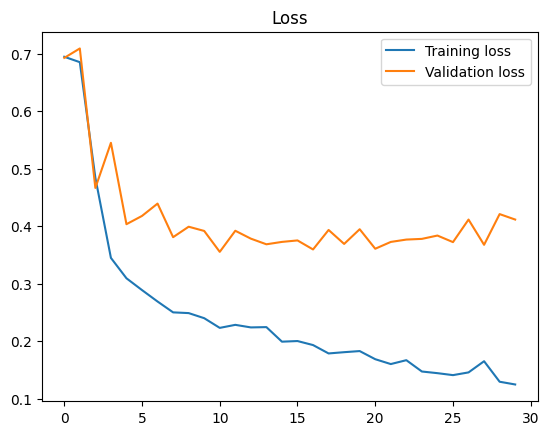

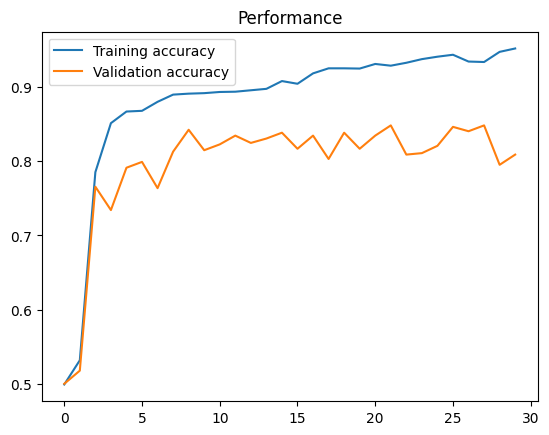

Accuracy on testing data: 0.83746
Matthews correlation coefficients: 1.000000
Training history appended to training_history_v3.xlsx


In [ ]:
print('Please wait patiently, training may take some seconds...')

# Create history variable
tr_hist = {'Date-time': [time.strftime('%Y-%m-%d %H:%M:%S')], 'Epochs': None, 'Training Loss': None, 'Training Accuracy': None,
                    'Validation Loss':None, 'Validation Accuracy': None, 'Optimizer': None,
                    'Learning rate': None, 'Momentum': None, 'WD': None, 'Betas': None, 'Eps': None, 'Dataset name': None, 
                   'Mini batch': mini_batch, 'Test Accuracy': None, 'Notes': None, 'MCC': None }


# Train your network here
#loss_function = torch.nn.CrossEntropyLoss()
#loss_function = torch.nn.BCEWithLogitsLoss()
loss_fun_name = "BCELoss"
#loss_function = lambda preds, targets: torch.nn.functional.binary_cross_entropy(preds, targets)
net = Network(num_classes=2).to(device)
optim_name = "adam" # adam, sgd
epochs = 30
net, tr_hist = train(net, train_loader, valid_loader, writer, val_writer, loss_fun_name, optim_name, dataset_name, tr_hist, epochs, device)

# Save the weight of current model to disk
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

# Load the model weights from './net.pth'
net.load_state_dict(torch.load('./net.pth'))

# Test the network on testing data
acc_test,_, preds, ground_truth = evaluate(net, loss_fun_name, test_loader, device)
mcc = matthews_corrcoef(ground_truth, preds)
print('Accuracy on testing data: {:.05f}'.format(acc_test))
print('Matthews correlation coefficients: {:05f}'.format(mcc))
# Add still to training history what is needed
tr_hist['Test Accuracy'] = acc_test
tr_hist['Notes'] = "WD 0"
tr_hist['MCC'] = mcc
# Convert the training history dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(tr_hist)

# Save the DataFrame to an Excel file, append to existing file if it exists
excel_file_path = 'training_history_v3.xlsx'
try:
    existing_df = pd.read_excel(excel_file_path)
    updated_df = pd.concat([existing_df, df.iloc[[-1]]], ignore_index=True)
    updated_df.to_excel(excel_file_path, index=False)
    print(f'Training history appended to {excel_file_path}')
except FileNotFoundError:
    df.to_excel(excel_file_path, index=False)
    print(f'Training history saved to {excel_file_path}')

# Close the training and validation writer
writer.close()
val_writer.close()

In [38]:
# Test the network on testing data
acc_test,_ = evaluate(net, loss_fun_name, test_loader, device)
print('Accuracy on testing data: {:.05f}'.format(acc_test))

# Close the training and validation writer
writer.close()
val_writer.close()

Accuracy on testing data: 0.82509


In [ ]:
# Option for using tensor board

#%load_ext tensorboard
%reload_ext tensorboard
#%tensorboard --logdir tb_graphs/ --port 5656
%tensorboard --logdir tb_graphs/train
